In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import Descriptors, rdmolops, AllChem
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
with open('data/filtered_labels_smiles.pkl', 'rb') as f:
    filtered_labels = pickle.load(f)
with open('data/filtered_mol_ls_smiles.pkl', 'rb') as f:
    filtered_mol_ls = pickle.load(f)

print(len(filtered_labels))

46719


# Predicting Denticity by Electronegative Atoms

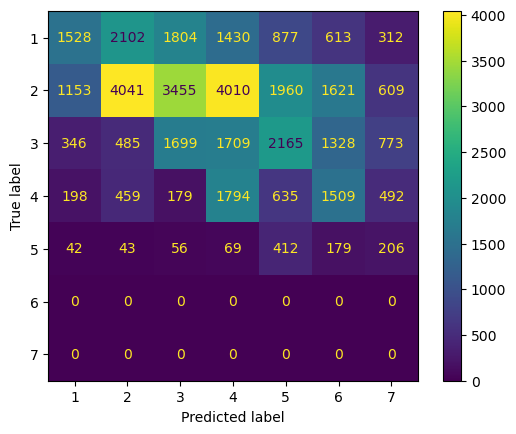

In [8]:
true_denticities = [sum(label) for label in filtered_labels]
common_catoms = [7, 8, 9, 17, 35, 53]
pred_denticities = [len([a.GetAtomicNum() for a in ligand.GetAtoms() if a.GetAtomicNum() in common_catoms])
                    for ligand in filtered_mol_ls]

cm = confusion_matrix(true_denticities, pred_denticities, labels=np.arange(1, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, 8))
disp.plot()
plt.savefig('figures/electronegativity_cm.png', dpi=300)

In [9]:
num_correct = 0

for i in range(len(true_denticities)):
    true = true_denticities[i]
    pred = pred_denticities[i]

    if true == pred:
        num_correct += 1

frac_correct = num_correct / len(true_denticities)
print(f'The fraction of structures that have their denticity predicted correctly is {frac_correct:1.3f}.')

The fraction of structures that have their denticity predicted correctly is 0.203.


# Predicting Denticity with Partial Charge

In [15]:
charge_list = []
label_list = []

for idx, mol in tqdm(enumerate(filtered_mol_ls), total=len(filtered_mol_ls)):
    try:
        molec_props = Chem.AllChem.MMFFGetMoleculeProperties(rdmolops.AddHs(mol))
    except:
        continue
    if molec_props:
        charges = np.array([molec_props.GetMMFFPartialCharge(i) for i, _ in enumerate(mol.GetAtoms())])
        charge_list.append(charges)
        label_list.append(filtered_labels[idx])
    else:
        pass
        '''
        print("MMFF charges not available for the input molecule, defaulting to Gasteiger charges.")
        AllChem.ComputeGasteigerCharges(mol)
        charges=np.array([a.GetDoubleProp('_GasteigerCharge') for a in mol.GetAtoms()])
        '''

 74%|███████▍  | 34740/46719 [00:05<00:02, 5934.04it/s][12:35:01] Can't kekulize mol.  Unkekulized atoms: 19 22 23 24 25 26 27 28 29 30 31 32 33
[12:35:01] Can't kekulize mol.  Unkekulized atoms: 16 19 20 21 22 23 24 25 26 27 28 29 30
100%|██████████| 46719/46719 [00:07<00:00, 6074.93it/s]


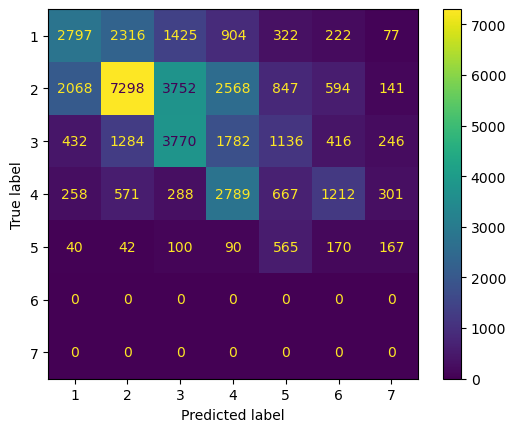

In [18]:
true_denticities = [sum(label) for label in label_list]
pred_denticities = [len(np.where(charges < -0.5)[0]) for charges in charge_list]

cm = confusion_matrix(true_denticities, pred_denticities, labels=np.arange(1, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, 8))
disp.plot()
plt.savefig('figures/partial_charge_cm.png', dpi=300)

In [19]:
num_correct = 0

for i in range(len(true_denticities)):
    true = true_denticities[i]
    pred = pred_denticities[i]

    if true == pred:
        num_correct += 1

frac_correct = num_correct / len(true_denticities)
print(f'The fraction of structures that have their denticity predicted correctly is {frac_correct:1.3f}.')

The fraction of structures that have their denticity predicted correctly is 0.369.
